# Training a model

Below is the example for a Gaussian Process regression using GpyTorch :class:`.ExactGaussianProcessRegressor`

This example shows how to use a GridInterpolationKernel module on an ExactGP model. This regression module is designed for when the inputs of the function you're modeling are one-dimensional.

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import ExactGaussianProcessRegressor

# Make plots inline
%matplotlib inline

In [2]:
# Training points are in [0,1] every 1/999
train_x = Variable(torch.linspace(0, 1, 1000))
# Function to model is sin(4*pi*x)
# Gaussian noise from N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
# Step 1: Define the GP model
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(-2, 2)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

In [4]:
# Step 2: Wrap the model into our GP Wrapper
GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 30,
)

# Step 3: Find optimal model hyperparameters
GP.fit(X=train_x, y=train_y)

# Step 4: Prediction
test_x = Variable(torch.linspace(0, 1, 51))
observed_pred = GP.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1       27.2577  0.2383
      2       26.7184  0.1729
      3       26.1261  0.1631
      4       25.2871  0.1618
      5       23.6488  0.1510
      6       20.7112  0.1482
      7       16.3476  0.1803
      8       11.3105  0.1680
      9        7.1211  0.1504
     10        4.5721  0.1448
     11        3.2293  0.1699
     12        2.4672  0.1732
     13        2.0025  0.1544
     14        1.7475  0.1497
     15        1.6375  0.1925
     16        1.5932  0.2015
     17        1.5767  0.1821
     18        1.5719  0.2120
     19        1.5689  0.2278
     20        1.5686  0.2205
     21        1.5637  0.1884
     22        1.5673  0.1802
     23        1.5705  0.1508
     24        1.5706  0.1525
     25        1.5708  0.1553
     26        1.5749  0.1571
     27        1.5708  0.1575
     28        1.5680  0.1546
     29        1.5763  0.1567
     30        1.5666  0.1539


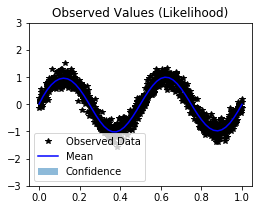

In [5]:
# (*) Step 5: Plotting
# Define plotting function
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

def ax_plot(ax, rand_var, title):
    # Get lower and upper predictive bounds
    lower, upper = rand_var.confidence_region()
    # Plot the training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GP),
])

pipe.fit(X=train_x.unsqueeze(-1), y=train_y) ## modify grid_bound above from (0,1) to (-2,2) to get it work

  epoch    train_loss     dur
-------  ------------  ------
      1        1.8303  0.1735
      2        1.6462  0.2344
      3        1.5930  0.2246
      4        1.5753  0.1916
      5        1.5712  0.1525
      6        1.5662  0.2004
      7        1.5673  0.1848
      8        1.5705  0.1492
      9        1.5694  0.1519
     10        1.5767  0.1480
     11        1.5716  0.1777
     12        1.5698  0.1662
     13        1.5703  0.1386
     14        1.5671  0.1514
     15        1.5678  0.1460
     16        1.5690  0.1438
     17        1.5686  0.1376
     18        1.5704  0.1443
     19        1.5657  0.1441
     20        1.5666  0.1393
     21        1.5646  0.1424
     22        1.5660  0.1510
     23        1.5635  0.1433
     24        1.5611  0.1449
     25        1.5645  0.1472
     26        1.5619  0.1525
     27        1.5624  0.1447
     28        1.5616  0.1512
     29        1.5662  0.1494
     30        1.5602  0.1499


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.ExactGaussianProcessRegressor'>[initialized](
  module_=GPRegressionModel(
    (likelihood): GaussianLikelihood()
    (mean_module): ConstantMean()
    (base_covar_module): RBFKernel()
    (covar_module): GridInterpolationKernel(
      (base_kernel_module): RBFKernel()
    )
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}
gs = GridSearchCV(GP, params, refit=False, cv=3, scoring='r2',
                 return_train_score=False)  # Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1       16.6868  0.1194
      2       16.5500  0.1165
      3       16.4011  0.1209
      4       16.2468  0.1242
      5       16.1061  0.1639
      6       15.9526  0.1280
      7       15.8088  0.1194
      8       15.6545  0.1157
      9       15.5064  0.1164
     10       15.3383  0.1225
  epoch    train_loss     dur
-------  ------------  ------
      1       19.2662  0.0964
      2       19.2568  0.1471
      3       19.2386  0.1463
      4       19.2206  0.1479
      5       19.2063  0.1567
      6       19.1972  0.1672
      7       19.1817  0.1663
      8       19.1664  0.1660
      9       19.1521  0.1286
     10       19.1275  0.1245
  epoch    train_loss     dur
-------  ------------  ------
      1       16.6585  0.0872
      2       16.5400  0.1209
      3       16.4134  0.1270
      4       16.2762  0.1233
      5       16.1524  0.1233
      6       16.0218  0.1170
      7       15.8952  0.1283
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`